In [1]:
import numpy as np
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt
import nibabel as nib
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

from nilearn import datasets,image
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image
import networkx as nx

c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [17]:
roi_time_series_list = []
for sub_id in range(1,25):
    if sub_id < 10: sub_id = f'0{sub_id}'
    # Load the fMRI data
    fmri_data_nii = nib.load(rf'E:\Datasets\movie_data\ds001145-download\sub-{sub_id}\func\sub-{sub_id}_task-watchmovie_bold.nii.gz')
    fmri_data = fmri_data_nii.get_fdata()

    # Load atlas for ROI definitions
    atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')

    # Resample atlas to match fMRI data
    atlas_resampled = image.resample_to_img(atlas.maps, fmri_data_nii, interpolation='nearest')

    # Select ROIs - this could be based on your specific needs
    selected_roi_labels = atlas['labels']  # up to 49 names

    # Extract the average time series for the selected ROIs
    roi_time_series = []
    for label in selected_roi_labels:
        roi_mask = image.math_img(f"np.where(img == {atlas.labels.index(label)}, 1, 0)", img=atlas_resampled)
        masked_data = fmri_data[roi_mask.get_fdata().astype(bool)]
        roi_time_series.append(masked_data.mean(axis=0))

    roi_time_series = np.array(roi_time_series)
    roi_time_series_list.append(roi_time_series)
roi_time_series = np.array(roi_time_series_list)


{'filename': 'C:\\Users\\LEGION/nilearn_data\\fsl\\data\\atlases\\HarvardOxford\\HarvardOxford-cort-maxprob-thr50-2mm.nii.gz', 'maps': <nibabel.nifti1.Nifti1Image object at 0x000001BBFFEAFDC0>, 'labels': ['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 

In [89]:
roi_time_series = np.array(roi_time_series_list)
print(roi_time_series.shape)
atlas['labels'][26] = 'Juxtapositional Lobule Cortex'

(24, 49, 1028)


In [92]:
corr_list_all = []
for sub_id in range(24):
    seed_func = roi_time_series[sub_id,10]
    corr_list = []
    for i in range(roi_time_series.shape[1]):
        if i==10 or i==0: continue
        corr = np.corrcoef(seed_func, roi_time_series[sub_id,i])[0,1]
        corr_list.append(corr)
    corr_list_all.append(np.array(corr_list))

In [91]:
corr_box_plot = np.array(corr_list_all)
corr_box_plot.shape

(24, 47)

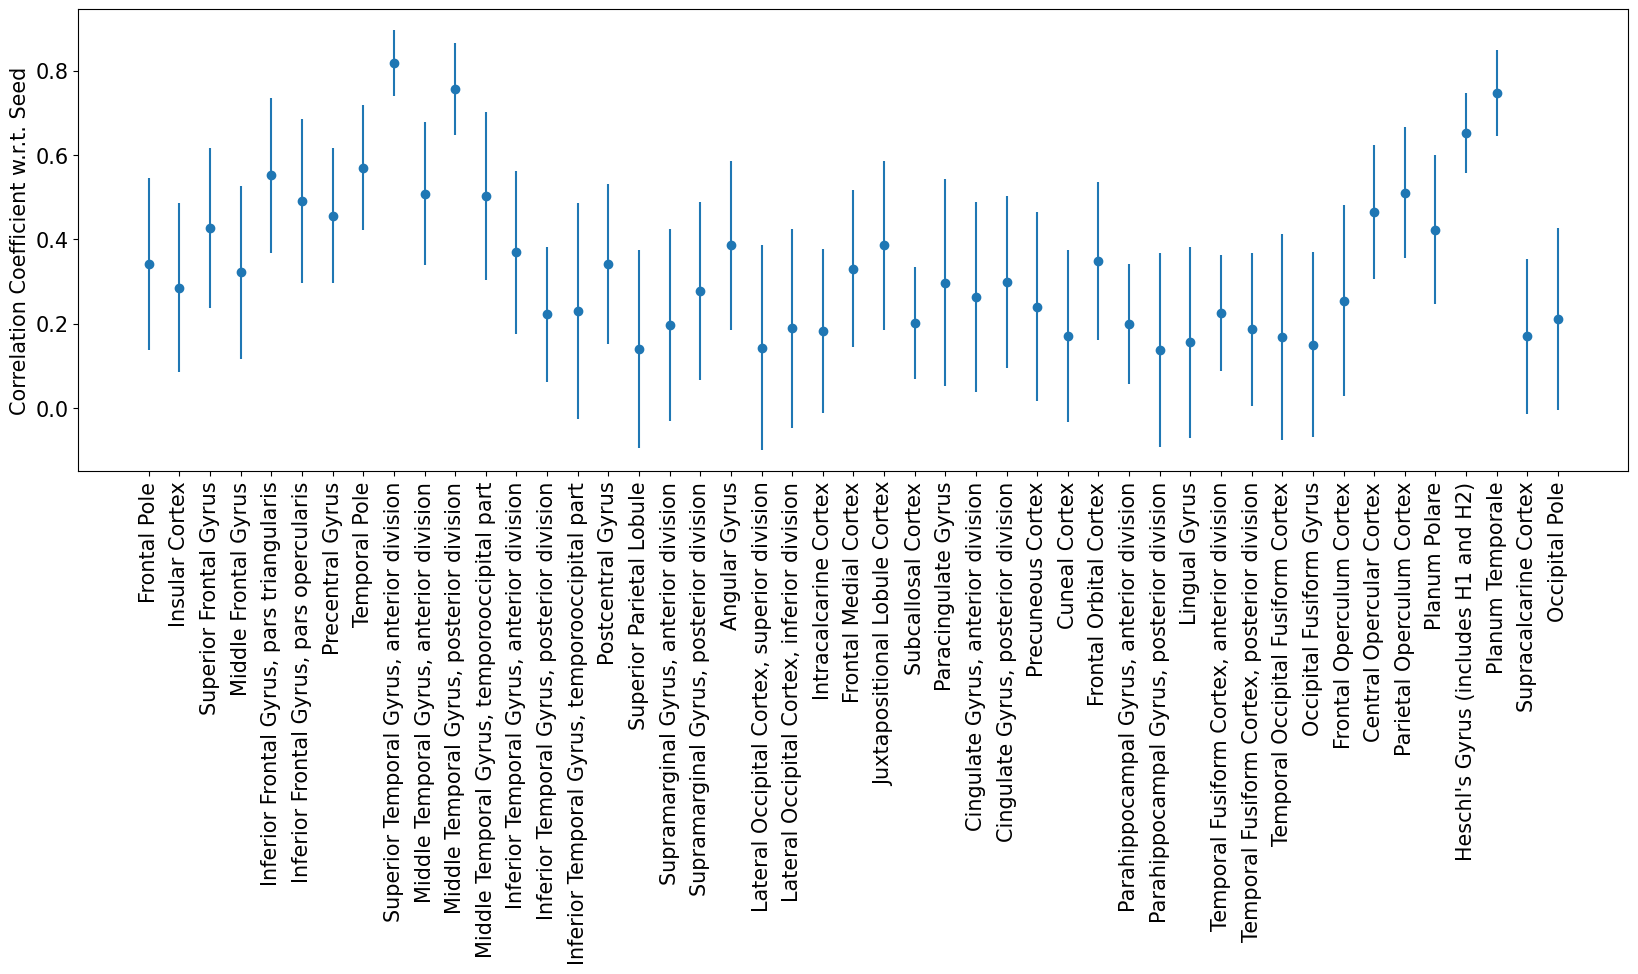

In [23]:
atlas['labels'][26] = 'Juxtapositional Lobule Cortex'
plt.figure(figsize=(20,6))
plt.errorbar(np.arange(corr_box_plot.shape[1]), corr_box_plot.mean(axis=0), yerr=corr_box_plot.std(axis=0), fmt="o")
plt.ylabel('Correlation Coefficient w.r.t. Seed',fontsize=15)
# plt.xlabel('Brain Region of Interest')
plt.yticks(fontsize=15)
plt.xticks(np.arange(47), atlas['labels'][1:10]+atlas['labels'][11:],fontsize=15, rotation=90)

plt.show()

In [36]:
roi_names=atlas['labels'][1:10]+atlas['labels'][11:]

top9_indices = np.argsort(corr_box_plot.mean(axis=0))[-9:].astype(int)
top9_roi_names = []
for i in range(len(top9_indices)):
    top9_roi_names.append(roi_names[top9_indices[i]])
print(top9_roi_names)

['Middle Temporal Gyrus, temporooccipital part', 'Middle Temporal Gyrus, anterior division', 'Parietal Operculum Cortex', 'Inferior Frontal Gyrus, pars triangularis', 'Temporal Pole', "Heschl's Gyrus (includes H1 and H2)", 'Planum Temporale', 'Middle Temporal Gyrus, posterior division', 'Superior Temporal Gyrus, anterior division']


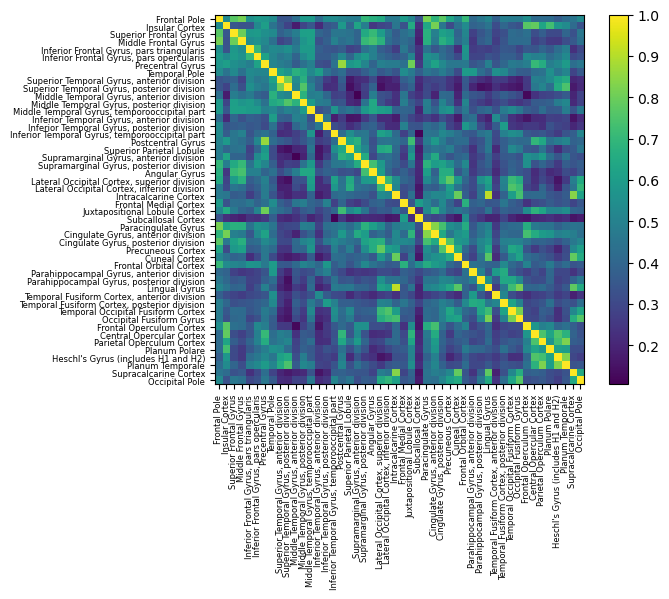

In [39]:
avg_corr_matr = np.zeros((49,49))
for i in range(24):
    corr_matr = np.corrcoef(roi_time_series[i])
    avg_corr_matr += corr_matr
avg_corr_matr /= 24
plt.imshow(avg_corr_matr[1:,1:])
plt.xticks(np.arange(48),atlas['labels'][1:],fontsize=6,rotation=90)
plt.yticks(np.arange(48),atlas['labels'][1:],fontsize=6)
plt.colorbar()
plt.show()

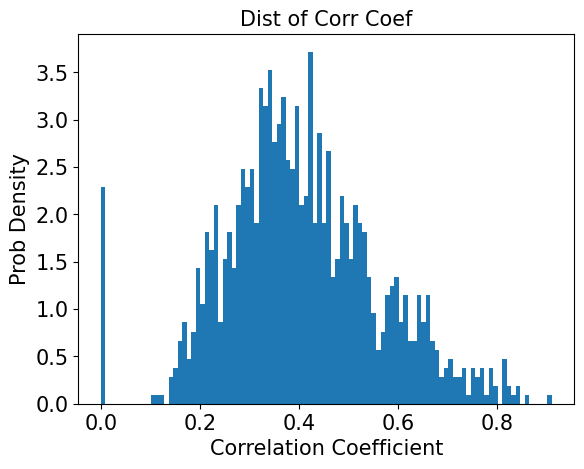

In [42]:
func_corr_matr = avg_corr_matr[1:,1:] - np.eye(48)
plt.hist(func_corr_matr.reshape(-1), bins=100,density=True)
plt.ylabel('Prob Density',fontsize=15)
plt.xlabel('Correlation Coefficient',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Dist of Corr Coef',fontsize=15)
plt.show()

In [43]:
def ComputeAdjacency(X):    
    return np.corrcoef(X)-np.diag(np.diag(np.corrcoef(X)))

def BinarizeAdjacency(A,rho):
    #Do not change the following three lines for extracting off-diagonal entries
    N = A.shape[0] #find the size of the matrix

    # Find the indices of the upper triangle
    ind = np.triu_indices(N, k=1)

    # Vectorize the element (strictly) above the main diagonal of the adjacency
    vec = A[ind] 

    # Declare output vector vec2
    vec2 = vec.copy()
    # Sort and flip (sorted returns from small to big)
    indmax = np.flip(np.argsort(vec))
    # Get the index of the maximum argument that we want to keep
    perc_keep = int(np.round(rho*len(vec)))
    # Declare output vector
    vec2 = np.zeros(vec.shape)
    # Use indexing with indmax to indicete the indices to set to 1 and 0. 
    vec2[indmax[0:perc_keep,]] = 1
    vec2[indmax[(perc_keep+1):],] = 0

    # Binarize the vector vec, and keep the result in the variable vec2
    # Declare A2
    A2 = np.zeros((N,N))
    # Set upper triangle to the data of vec2
    A2[ind] = vec2
    # Add it to its transpose, to fill the lower triangle while
    A2=A2+A2.T
    # Make sure that the diagonal is filled with 0s
    A2 = A2 - np.diag(np.diag(A2))
    
    return A2

bin_func_con = BinarizeAdjacency(func_corr_matr, .3)

def ComputeC(adj1):
    
    ccoefs = nx.algorithms.cluster.clustering(nx.from_numpy_array(adj1.astype(int)))
    
    return np.asarray(list(ccoefs.values()))

C_list = ComputeC(bin_func_con)

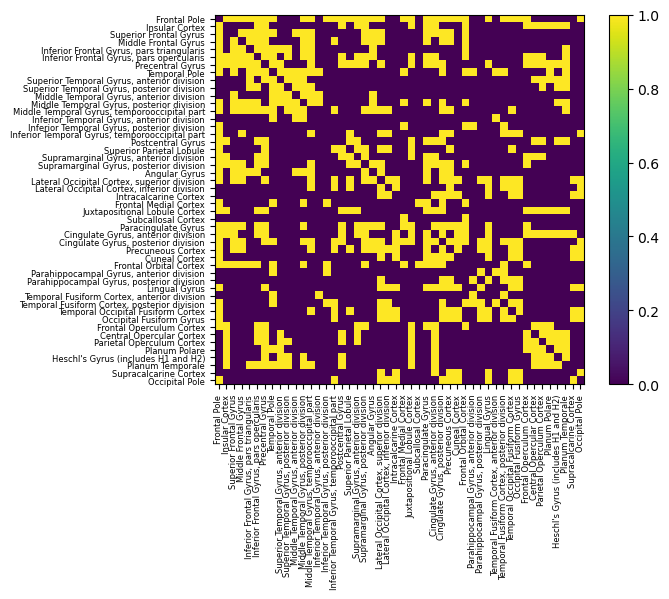

In [47]:
plt.imshow(bin_func_con)
plt.xticks(np.arange(48),atlas['labels'][1:],fontsize=6,rotation=90)
plt.yticks(np.arange(48),atlas['labels'][1:],fontsize=6)
plt.colorbar()
plt.show()

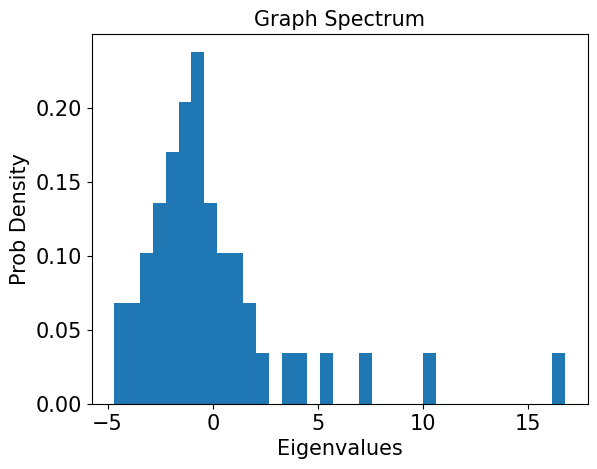

In [50]:
plt.hist(np.linalg.eigvals(bin_func_con), bins=35,density=True)
plt.ylabel('Prob Density',fontsize=15)
plt.xlabel('Eigenvalues',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Graph Spectrum',fontsize=15)
plt.show()

(48, 48)


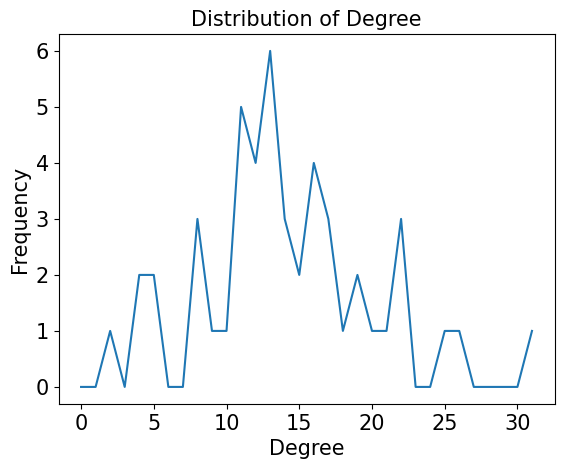

In [60]:
def degree_distribution(adjacency_matrix):
    """
    Calculate the degree distribution of a graph from its adjacency matrix.

    :param adjacency_matrix: A square numpy array representing the adjacency matrix of a graph
    :return: A list where the i-th element is the number of nodes with degree i
    """
    # Ensure the adjacency matrix is square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], "Adjacency matrix must be square."

    # Summing along axis 1 computes the degree of each node (row)
    degrees = adjacency_matrix.sum(axis=1)
    
    # The maximum degree is the length of our distribution list
    max_degree = degrees.max()

    # Initialize a list to hold the degree distribution
    degree_distribution = [0] * (max_degree + 1)
    
    # Count the frequencies of each degree in the graph
    for degree in degrees:
        degree_distribution[degree] += 1

    return degree_distribution
print(bin_func_con.shape)
plt.plot(np.arange(len(degree_distribution(bin_func_con.astype(int)))), degree_distribution(bin_func_con.astype(int)))
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Degree',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Distribution of Degree',fontsize=15)
plt.show()

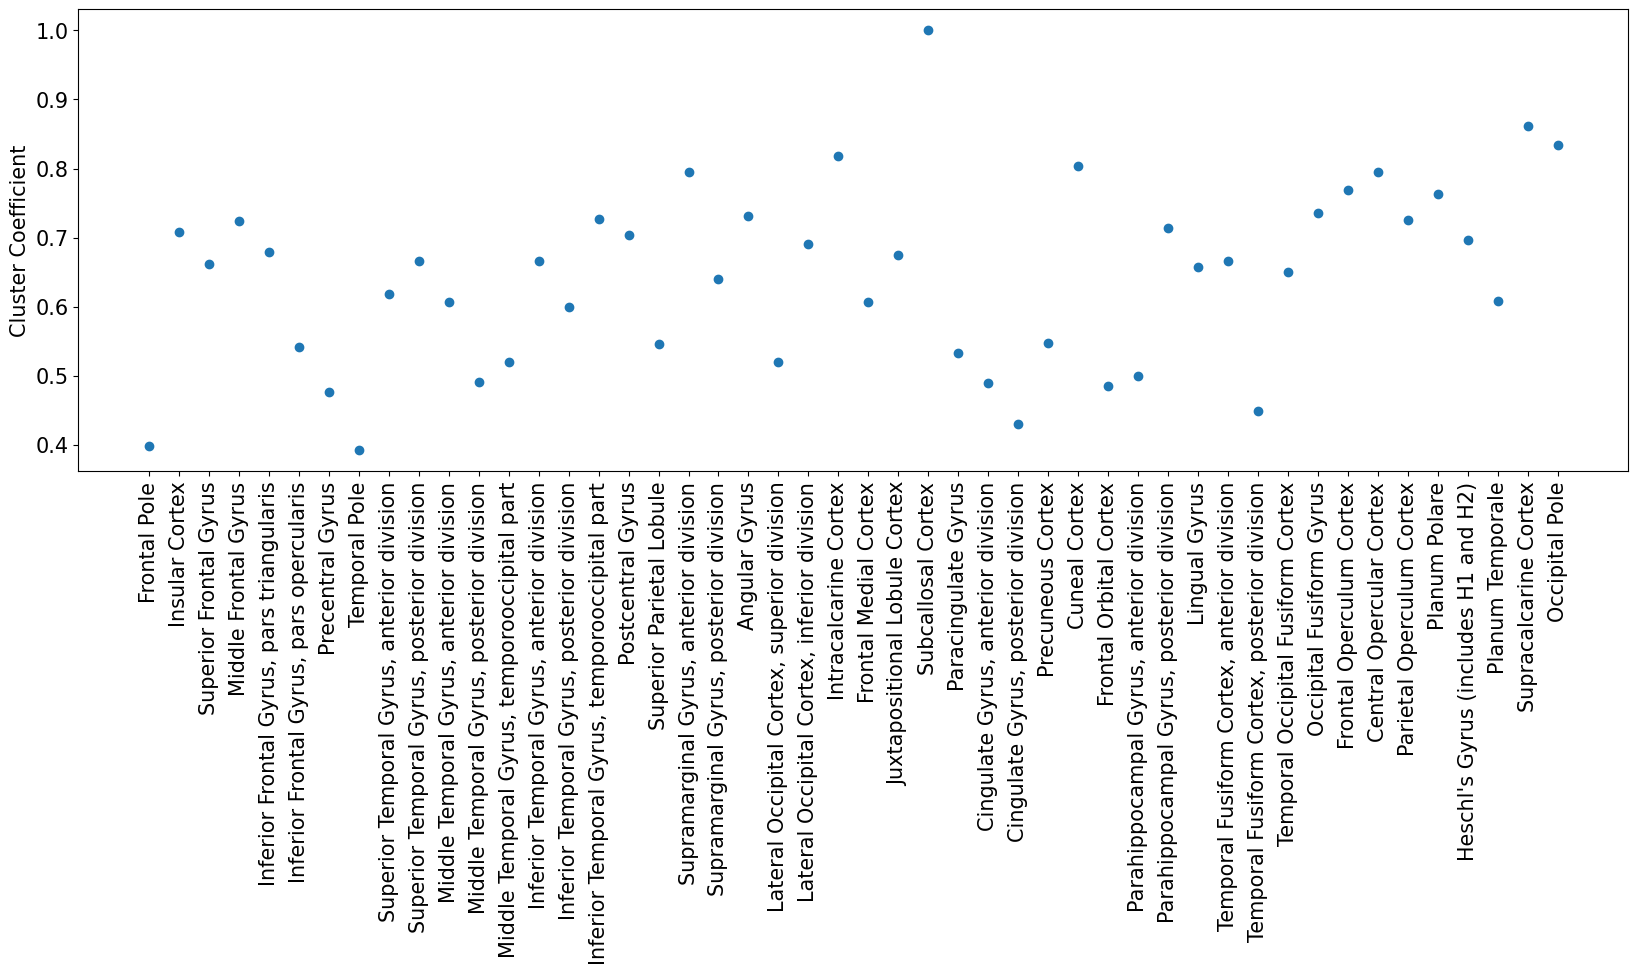

In [46]:
plt.figure(figsize=(20,6))
plt.errorbar(np.arange(48), C_list, yerr=0, fmt="o")
plt.ylabel('Cluster Coefficient',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(48), atlas['labels'][1:],fontsize=15, rotation=90)

plt.show()

In [147]:
top10_roi_names = top9_roi_names + ['Superior Temporal Gyrus, posterior division']
top10_roi_names
top10_roi_names_short = [
    'MTG-t',
    'MTG-a',
    'POC',
    'IFG-pt',
    'Temporal Pole',
    "Heschl's Gyrus",
    'Planum Temporale',
    'MTG-p',
    'STG-a',
    'STG-p'
]

In [148]:
name_map = {k:v for (k,v) in zip(indices, top10_roi_names_short)}
atlas['labels'][1:]

['Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex',
 'Subcallosal Cortex',
 'Paracingulate Gyrus',
 'Cingulate Gyru

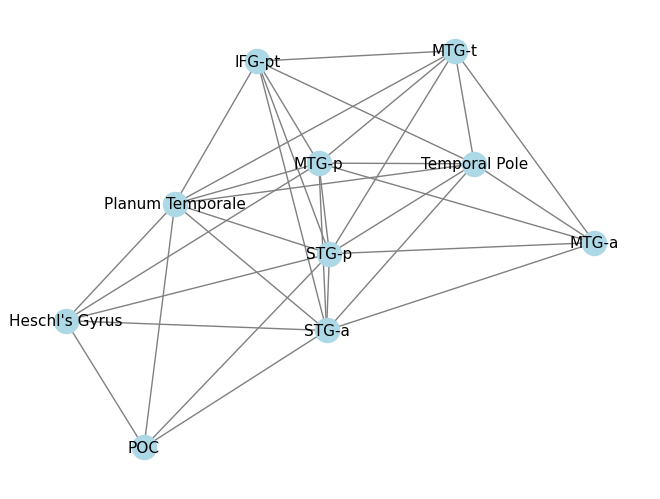

In [151]:
def visualize_subgraph(adjacency_matrix, subgraph_nodes,new_labels=None):
    """
    Visualize a subgraph specified by the subgraph_nodes from a graph described by the adjacency_matrix.

    :param adjacency_matrix: A numpy array representing the adjacency matrix of the full graph.
    :param subgraph_nodes: A list of nodes to include in the subgraph.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Generate subgraph
    H = G.subgraph(subgraph_nodes)
    if new_labels:
        H = nx.relabel_nodes(H, new_labels)
    # Draw the subgraph
    # plt.figure(figsize=(10,10))
    pos = nx.spring_layout(H)  # positions for all nodes
    nx.draw(H, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=11)
    
    plt.show()

def find_subgraph(adj_matrix, nodes):
    """
    Visualize a subgraph specified by 'nodes' and return its adjacency matrix.

    :param adj_matrix: The adjacency matrix of the full graph.
    :param nodes: List of nodes to include in the subgraph.
    :return: Adjacency matrix of the subgraph.
    """
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    
    # Generate the subgraph
    subgraph = G.subgraph(nodes)
    
    # Get the adjacency matrix of the subgraph as a numpy array
    sub_adj_matrix = nx.to_numpy_array(subgraph)
    
    return sub_adj_matrix

visualize_subgraph(bin_func_con, [12, 10, 42, 4, 7, 44, 45, 11, 8, 9],new_labels=name_map)
sub_adj = find_subgraph(bin_func_con, [12, 10, 42, 4, 7, 44, 45, 11, 8, 9])

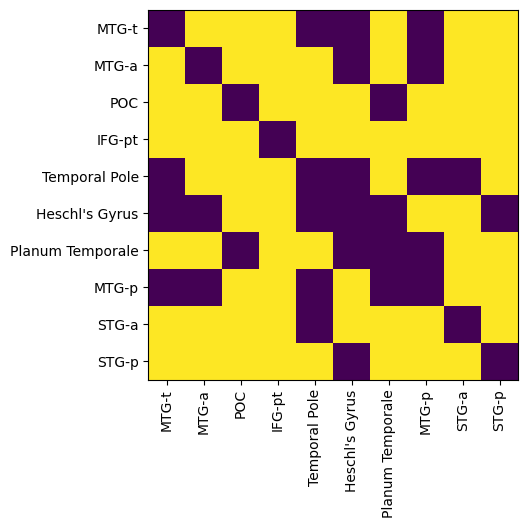

In [154]:
plt.imshow(sub_adj)
plt.xticks(np.arange(10),top10_roi_names_short,fontsize=10,rotation=90)
plt.yticks(np.arange(10),top10_roi_names_short,fontsize=10)
plt.show()

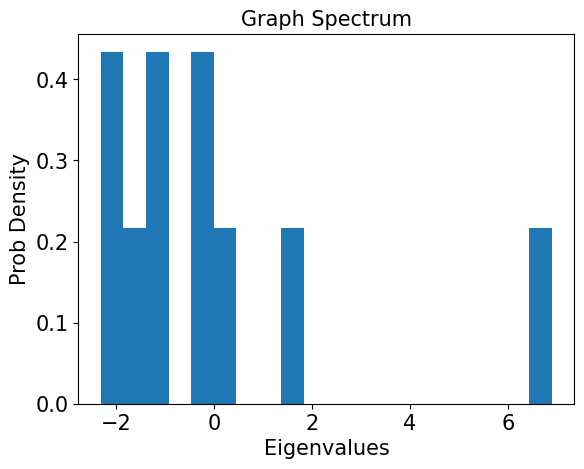

In [156]:
plt.hist(np.linalg.eigvals(sub_adj), bins=20,density=True)
plt.ylabel('Prob Density',fontsize=15)
plt.xlabel('Eigenvalues',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Graph Spectrum',fontsize=15)
plt.show()

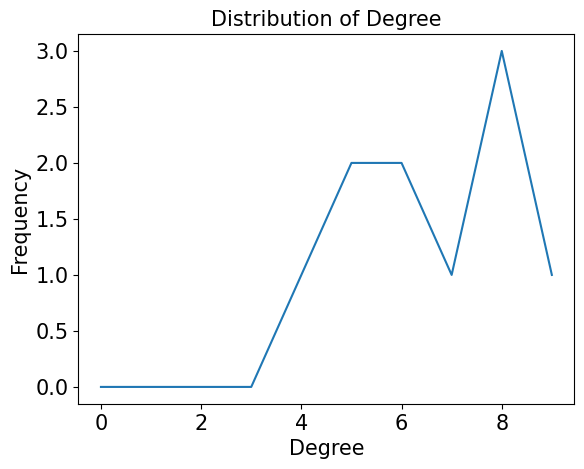

In [161]:
plt.plot(np.arange(len(degree_distribution(sub_adj.astype(int)))), degree_distribution(sub_adj.astype(int)))
plt.ylabel('Frequency',fontsize=15)
plt.xlabel('Degree',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Distribution of Degree',fontsize=15)
plt.show()

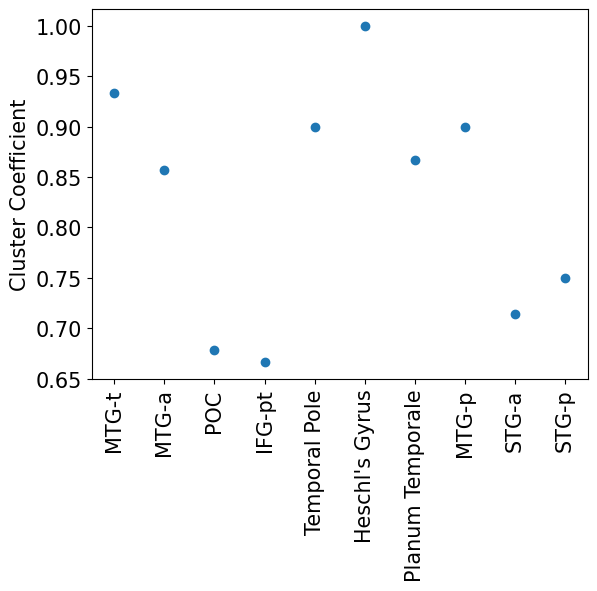

In [163]:
C_list = ComputeC(sub_adj)
# plt.figure(figsize=(20,6))
plt.errorbar(np.arange(10), C_list, yerr=0, fmt="o")
plt.ylabel('Cluster Coefficient',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(10), top10_roi_names_short, fontsize=15, rotation=90)

plt.show()